In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Original

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, state, spin, is_lost = mol[:, 0], mol[:, 1], mol[:, 2], mol[:,3], mol[:,4], mol[:, 5]
    mask = (is_lost == 0) & (state == 1) & (spin == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0)
    raw = int(cp.count_nonzero(mask).get())
    return raw

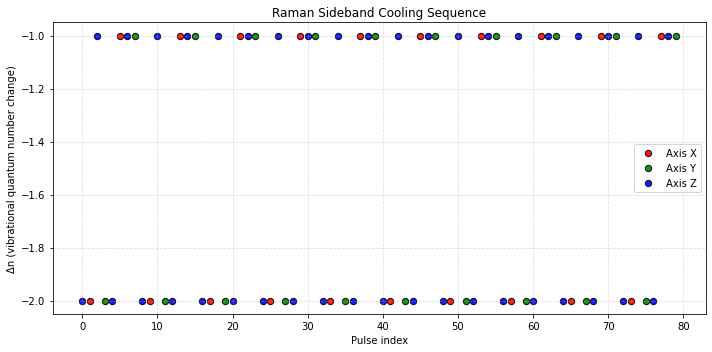

In [3]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks

# Repeat each block along the first axis, then concatenate in order
blocks = [
    cp.tile(original_gpu[4], (10, 1)),  # repeat 5 times
]

seq_gpu = cp.concatenate(blocks, axis=0)
cr.visualize_sequence(seq_gpu)

In [4]:
np.save("XYZ4_original.npy", cp.asarray(seq_gpu))

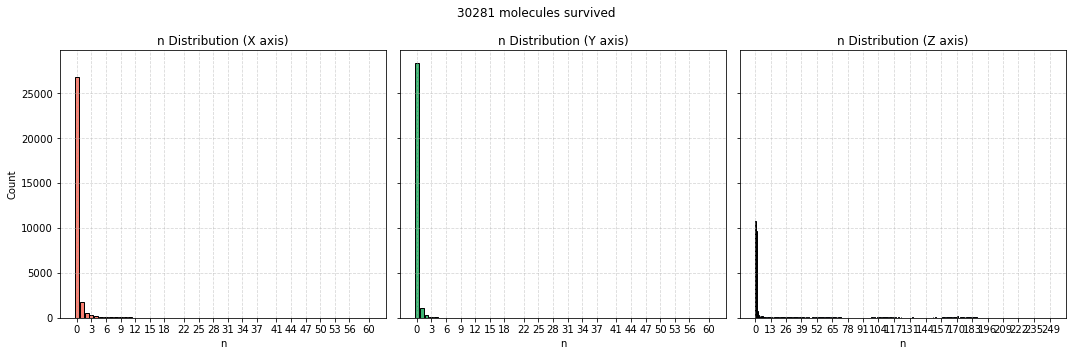

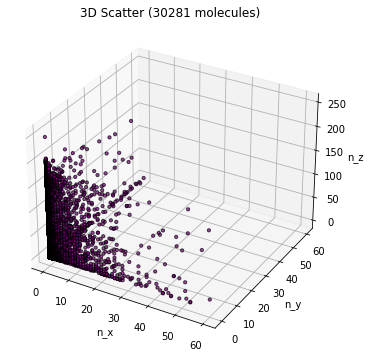

Raman pulses: 100%|██████████| 80/80 [00:43<00:00,  1.85it/s]


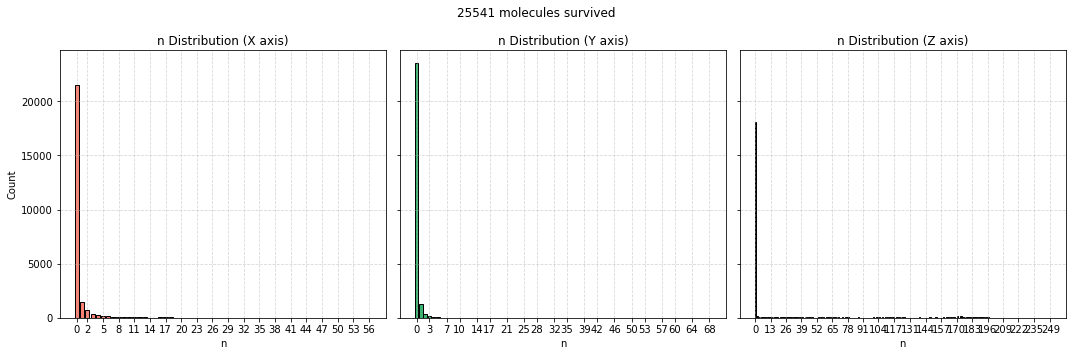

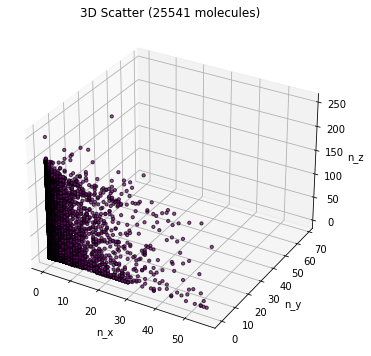

survival_rate_mean 0.51082
mot_mean [ 0.86492306  0.20218472 29.62303747]
mot_sem [0.00073485 0.00032798 0.01171216]


In [5]:
mol_0 = cp.asarray(np.load("mol_post_XYZ3.npy"))
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)
cr.raman_cool_with_pumping(mol_0, seq_gpu, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [6]:
score_sequence(mol_0)

17343

#### Optimized

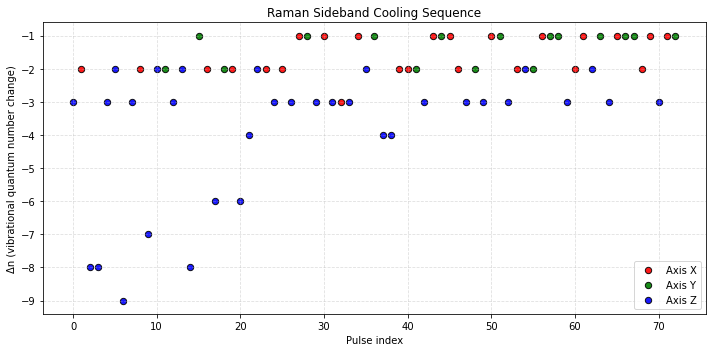

In [6]:
seq_op = cp.array(np.load("ga_runs/XYZ3_20251031_153905/final_top5/top1_sequence.npy"))
cr.visualize_sequence(seq_op)

Raman pulses: 100%|██████████| 73/73 [00:39<00:00,  1.85it/s]


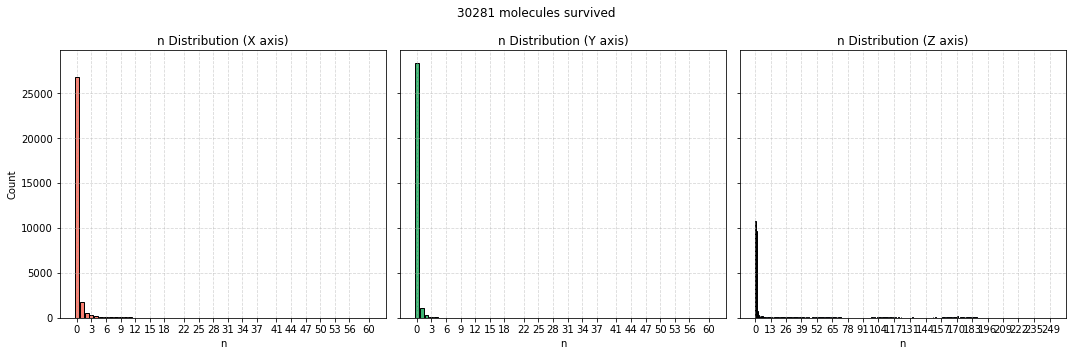

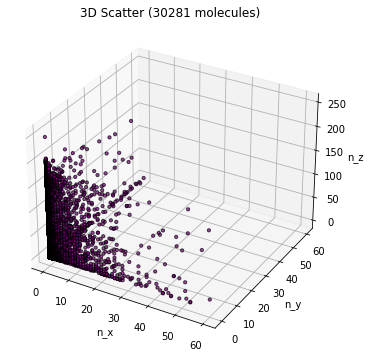

survival_rate_mean 0.60562
mot_mean [ 0.48558502  0.24698656 25.55126977]
mot_sem [0.00049157 0.00037208 0.00981227]


In [7]:
mol_1 = cp.asarray(np.load("mol_post_XYZ2.npy"))
cr.raman_cool_with_pumping(mol_1, seq_op, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_1, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_1)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [8]:
score_sequence(mol_1)

20202

In [9]:
cr.save_molecules(mol_1, "post_XYZ3.npy")

[✓] Molecules saved to: C:\Users\LyuQi\Documents\optimize_sequence\XYZ3\post_XYZ3.npy  (shape=(50000, 6))
